In [1]:
# PyTorch imports
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
# DLC Practical prologue
import dlc_practical_prologue as prologue
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import hiddenlayer as hl

# Load Data

In [2]:
N = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)

In [3]:
# Data sizes for reference
print('Train input:', train_input.size())
print('Train target:', train_target.size())
print('Train classes:', train_classes.size())

print('\nTest input:', test_input.size())
print('Test target:', test_target.size())
print('Test classes:', test_classes.size())

Train input: torch.Size([1000, 2, 14, 14])
Train target: torch.Size([1000])
Train classes: torch.Size([1000, 2])

Test input: torch.Size([1000, 2, 14, 14])
Test target: torch.Size([1000])
Test classes: torch.Size([1000, 2])


# Model Architectures

### Fully Connected Model

Architecture


          Layer (type)               Output Shape         Param
================================================================

            input               [-1, 2, 14, 14]               0
            Linear-1                   [-1, 50]           9,850
           Dropout-2                   [-1, 50]               0
            Linear-3                   [-1, 10]             510
            Linear-4                   [-1, 50]           9,850
           Dropout-5                   [-1, 50]               0
            Linear-6                   [-1, 10]             510
            Linear-7                   [-1, 20]             420
            Linear-8                    [-1, 2]              42

================================================================

- The number of Trainable parameters without weight sharing: 21,182 
- The number of Trainable parameters with weight sharing: 10,822

In [4]:
class fullyconnected(nn.Module):
    # Init method
    def __init__(self, use_weight_sharing_, use_auxiliary_loss_):
        super().__init__()
        self.use_weight_sharing = use_weight_sharing_
        self.use_auxiliary_loss = use_auxiliary_loss_
        
        # X1
        self.x1_fc1 = nn.Linear(196, 50)
        self.x1_fc2 = nn.Linear(50, 10)
        
        # X2
        if not self.use_weight_sharing:
            self.x2_fc1 = nn.Linear(196, 50)
            self.x2_fc2 = nn.Linear(50, 10)
                
        # Combine
        self.comp_fc1 = nn.Linear(20, 20)
        self.comp_fc2 = nn.Linear(20, 2)
        # Dropout
        self.dropout=nn.Dropout()
        
    # Forward method    
    def forward(self, x):
        # X1
        x1 = x[:,0:1] 
        x1 = x1.reshape(x1.size(0), -1)
        x1 = self.dropout(F.relu(self.x1_fc1(x1)))
        x1 = F.relu(self.x1_fc2(x1))
        
        # X2
        x2 = x[:,1:2] 
        x2 = x2.reshape(x2.size(0), -1)
        if not self.use_weight_sharing:
            x2 = self.dropout(F.relu(self.x2_fc1(x2)))
            x2 = F.relu(self.x2_fc2(x2))

        else: 
            x2 = self.dropout(F.relu(self.x1_fc1(x2)))
            x2 = F.relu(self.x1_fc2(x2))        
        
        # Combine
        x = torch.cat((x1, x2), 1)
        x = F.relu(self.comp_fc1(x))
        x = self.comp_fc2(x)
        
        if self.use_auxiliary_loss:
            return x, x1, x2
        else:
            return x

### Simple Convolutional Model

Architecture

        Layer (type)               Output Shape         Param
================================================================

            input               [-1, 2, 14, 14]               0
            Conv2d-1           [-1, 10, 14, 14]             100
         MaxPool2d-2           [-1, 10, 12, 12]               0
           Dropout-3           [-1, 10, 12, 12]               0
            Conv2d-4           [-1, 10, 12, 12]             910
         MaxPool2d-5             [-1, 10, 6, 6]               0
           Dropout-6             [-1, 10, 6, 6]               0
            Linear-7                   [-1, 10]           3,610
            Conv2d-8           [-1, 10, 14, 14]             100
         MaxPool2d-9           [-1, 10, 12, 12]               0
          Dropout-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 10, 12, 12]             910
        MaxPool2d-12             [-1, 10, 6, 6]               0
          Dropout-13             [-1, 10, 6, 6]               0
           Linear-14                   [-1, 10]           3,610
           Linear-15                   [-1, 20]             420
           Linear-16                    [-1, 2]              42

================================================================

- The number of Trainable parameters without weight sharing: 9,702 
- The number of Trainable parameters with weight sharing: 5,082 

In [5]:
class simpleCNN(nn.Module):
    # Init method
    def __init__(self, use_weight_sharing_, use_auxiliary_loss_):
        super().__init__()
        self.use_weight_sharing = use_weight_sharing_
        self.use_auxiliary_loss = use_auxiliary_loss_
        self.conv_out = 10*6*6
        
        # X1
        self.x1_conv1 = nn.Conv2d(1, 10, kernel_size=3, padding=1)
        self.x1_conv2 = nn.Conv2d(10, 10, kernel_size=3, padding=1)
        self.x1_fc1 = nn.Linear(self.conv_out, 10)
        
        # X2
        if not self.use_weight_sharing:
            self.x2_conv1 = nn.Conv2d(1, 10, kernel_size=3, padding=1)
            self.x2_conv2 = nn.Conv2d(10, 10, kernel_size=3, padding=1)
            self.x2_fc1 = nn.Linear(self.conv_out, 10)
        
        # common
        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=1)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Combine
        self.comp_fc1 = nn.Linear(20, 20)
        self.comp_fc2 = nn.Linear(20, 2)
        # Dropout
        self.dropout = nn.Dropout()
        
    # Forward method    
    def forward(self, x):
        # X1
        x1 = x[:,0:1]
        x1 = self.dropout(F.relu(self.max_pool1(self.x1_conv1(x1))))
        x1 = self.dropout(F.relu(self.max_pool2(self.x1_conv2(x1))))
        x1 = x1.reshape(x1.size(0), -1)
        x1 = self.x1_fc1(x1)
        
        # X2
        x2 = x[:,1:2]
        if not self.use_weight_sharing:
            x2 = self.dropout(F.relu(self.max_pool1(self.x2_conv1(x2))))
            x2 = self.dropout(F.relu(self.max_pool2(self.x2_conv2(x2))))
            x2 = x2.reshape(x2.size(0), -1)
            x2 = self.x2_fc1(x2)
        else: 
            x2 = self.dropout(F.relu(self.max_pool1(self.x1_conv1(x2))))
            x2 = self.dropout(F.relu(self.max_pool2(self.x1_conv2(x2))))
            x2 = x2.reshape(x2.size(0), -1)
            x2 = self.x1_fc1(x2)         
        
        # Combine
        x = torch.cat((x1, x2), 1)
        x = F.relu(self.comp_fc1(x))
        x = self.comp_fc2(x)
        
        if self.use_auxiliary_loss:
            return x, x1, x2
        else:
            return x

### Convolutional Model with skip connections

Architecture


        Layer (type)               Output Shape         Param
================================================================

            input               [-1, 2, 14, 14]               0
            Conv2d-1           [-1, 14, 12, 12]             140
            Conv2d-2           [-1, 14, 12, 12]           1,778
       BatchNorm2d-3           [-1, 14, 12, 12]              28
            Conv2d-4           [-1, 14, 12, 12]           1,778
       BatchNorm2d-5           [-1, 14, 12, 12]              28
          ResBlock-6           [-1, 14, 12, 12]               0
            Conv2d-7           [-1, 14, 12, 12]           1,778
       BatchNorm2d-8           [-1, 14, 12, 12]              28
            Conv2d-9           [-1, 14, 12, 12]           1,778
      BatchNorm2d-10           [-1, 14, 12, 12]              28
         ResBlock-11           [-1, 14, 12, 12]               0
           Conv2d-12           [-1, 14, 12, 12]           1,778
      BatchNorm2d-13           [-1, 14, 12, 12]              28
           Conv2d-14           [-1, 14, 12, 12]           1,778
      BatchNorm2d-15           [-1, 14, 12, 12]              28
         ResBlock-16           [-1, 14, 12, 12]               0
           Conv2d-17           [-1, 14, 12, 12]           1,778
      BatchNorm2d-18           [-1, 14, 12, 12]              28
           Conv2d-19           [-1, 14, 12, 12]           1,778
      BatchNorm2d-20           [-1, 14, 12, 12]              28
         ResBlock-21           [-1, 14, 12, 12]               0
           Conv2d-22           [-1, 14, 12, 12]           1,778
      BatchNorm2d-23           [-1, 14, 12, 12]              28
           Conv2d-24           [-1, 14, 12, 12]           1,778
      BatchNorm2d-25           [-1, 14, 12, 12]              28
         ResBlock-26           [-1, 14, 12, 12]               0
           Conv2d-27           [-1, 14, 12, 12]           1,778
      BatchNorm2d-28           [-1, 14, 12, 12]              28
           Conv2d-29           [-1, 14, 12, 12]           1,778
      BatchNorm2d-30           [-1, 14, 12, 12]              28
         ResBlock-31           [-1, 14, 12, 12]               0
        AvgPool2d-32             [-1, 14, 1, 1]               0
           Linear-33                   [-1, 10]             150
           Conv2d-34           [-1, 14, 12, 12]             140
           Conv2d-35           [-1, 14, 12, 12]           1,778
      BatchNorm2d-36           [-1, 14, 12, 12]              28
           Conv2d-37           [-1, 14, 12, 12]           1,778
      BatchNorm2d-38           [-1, 14, 12, 12]              28
         ResBlock-39           [-1, 14, 12, 12]               0
           Conv2d-40           [-1, 14, 12, 12]           1,778
      BatchNorm2d-41           [-1, 14, 12, 12]              28
           Conv2d-42           [-1, 14, 12, 12]           1,778
      BatchNorm2d-43           [-1, 14, 12, 12]              28
         ResBlock-44           [-1, 14, 12, 12]               0
           Conv2d-45           [-1, 14, 12, 12]           1,778
      BatchNorm2d-46           [-1, 14, 12, 12]              28
           Conv2d-47           [-1, 14, 12, 12]           1,778
      BatchNorm2d-48           [-1, 14, 12, 12]              28
         ResBlock-49           [-1, 14, 12, 12]               0
           Conv2d-50           [-1, 14, 12, 12]           1,778
      BatchNorm2d-51           [-1, 14, 12, 12]              28
           Conv2d-52           [-1, 14, 12, 12]           1,778
      BatchNorm2d-53           [-1, 14, 12, 12]              28
         ResBlock-54           [-1, 14, 12, 12]               0
           Conv2d-55           [-1, 14, 12, 12]           1,778
      BatchNorm2d-56           [-1, 14, 12, 12]              28
           Conv2d-57           [-1, 14, 12, 12]           1,778
      BatchNorm2d-58           [-1, 14, 12, 12]              28
         ResBlock-59           [-1, 14, 12, 12]               0
           Conv2d-60           [-1, 14, 12, 12]           1,778
      BatchNorm2d-61           [-1, 14, 12, 12]              28
           Conv2d-62           [-1, 14, 12, 12]           1,778
      BatchNorm2d-63           [-1, 14, 12, 12]              28
         ResBlock-64           [-1, 14, 12, 12]               0
        AvgPool2d-65             [-1, 14, 1, 1]               0
           Linear-66                   [-1, 10]             150
           Linear-67                   [-1, 20]             420
           Linear-68                    [-1, 2]              42
           
================================================================


- The number of Trainable parameters without weight sharing: 44,386 
- The number of Trainable parameters with weight sharing: 22,424

Shown below is the ResBlock:
![ResBlock](./tmpResBlock.jpg "ResBlock")

**Credits Missing**

In [6]:
# To be used in the Residual Network
class ResBlock(nn.Module):
    def __init__(self, nb_channels, kernel_size):
        super().__init__()
        
        self.conv1 = nn.Conv2d(nb_channels, nb_channels, kernel_size, padding = (kernel_size-1)//2)
        self.bn1 = nn.BatchNorm2d(nb_channels)
        self.conv2 = nn.Conv2d(nb_channels, nb_channels, kernel_size, padding = (kernel_size-1)//2)
        self.bn2 = nn.BatchNorm2d(nb_channels)
        
    def forward(self, x):
        y = self.bn1(self.conv1(x))
        y = F.relu(y)
        y = self.bn2(self.conv2(y))
        y += x
        y = F.relu(y)
        return y

In [7]:
class skipCNN(nn.Module):
    # Init method
    def __init__(self, use_weight_sharing_, use_auxiliary_loss_):
        super().__init__()
        self.use_weight_sharing = use_weight_sharing_
        self.use_auxiliary_loss = use_auxiliary_loss_
        self.rb_kernel_size = 3  # Odd size expected
        self.nb_blocks = 6
        
        # X1
        self.x1_conv0 = nn.Conv2d(1, 14, kernel_size=3)
        self.x1_resblocks = nn.Sequential(*(ResBlock(14, self.rb_kernel_size) for _ in range(self.nb_blocks)))
        self.x1_avg = nn.AvgPool2d(kernel_size=12)
        self.x1_fc = nn.Linear(14, 10)
        
        # X2
        if not self.use_weight_sharing:
            self.x2_conv0 = nn.Conv2d(1, 14, kernel_size=3)
            self.x2_resblocks = nn.Sequential(*(ResBlock(14, self.rb_kernel_size) for _ in range(self.nb_blocks)))
            self.x2_avg = nn.AvgPool2d(kernel_size=12)
            self.x2_fc = nn.Linear(14, 10)
            
        # Combine
        self.comp_fc1 = nn.Linear(20, 20)
#         self.comp_fc2 = nn.Linear(100, 50)
        self.comp_fc3 = nn.Linear(20, 2)
        # Dropout
        self.dropout=nn.Dropout()
        
    # Forward method
    def forward(self, x):
        # X1
        x1 = F.relu(self.x1_conv0(x[:,0:1]))
        x1 = self.x1_resblocks(x1)
        x1 = F.relu(self.x1_avg(x1))
        x1 = x1.view(x1.size(0), -1)
        x1 = self.x1_fc(x1)
        
        # X2
        if not self.use_weight_sharing:
            x2 = F.relu(self.x2_conv0(x[:,1:2]))
            x2 = self.x2_resblocks(x2)
            x2 = F.relu(self.x2_avg(x2))
            x2 = x2.view(x2.size(0), -1)
            x2 = self.x2_fc(x2)
        else:
            x2 = F.relu(self.x1_conv0(x[:,1:2]))
            x2 = self.x1_resblocks(x2)
            x2 = F.relu(self.x1_avg(x2))
            x2 = x2.view(x2.size(0), -1)
            x2 = self.x1_fc(x2)
            
        # Combine
        x = F.relu(self.comp_fc1(torch.cat((x1, x2), 1)))
#         x = F.relu(self.comp_fc2(x))
        x = self.comp_fc3(x)
        if self.use_auxiliary_loss:
            return x, x1, x2 
        else:
            return x

# Methods for Training and Testing

## Train Model

In [8]:
def train_model(model_type, train_input, train_target, train_classes, test_input, test_target, test_classes, 
                mini_batch_size, nb_epochs, nb_iterations):
    '''
    Trains the specified model using train_data and tests the model using the
    compute_nb_errors function and returns errors and losses.
    '''
    
    # function returns
    train_outputs = []
    
    # Initialize model parameters
    model = None
    eta = 1e-1
    alpha = 0.2
    net_types = [(False, False), (True, False), (False, True), (True, True)]
    
    # Iterate for four possible cases
    for (use_weight_sharing, use_auxiliary_loss) in net_types:
        
        freturns = {"weight_sharing": use_weight_sharing, "auxiliary_loss": use_auxiliary_loss,
                    "loss": [], "loss1": [], "loss2": [], "loss3": [],
                    "error": [], "error1": [], "error2": [],
                    "mean_error": [], "std_error": []}
        
        print('\nTraining', '-'*60)
        print('Using Weight Sharing:', use_weight_sharing)
        print('Using Auxiliary Loss:', use_auxiliary_loss)        
        
        all_errors = torch.empty(nb_iterations)
        
        # Iterate for performance estimation
        for k in range(nb_iterations):
            # Define the training model
            if model_type == 'fullyconnected':
                model = fullyconnected(use_weight_sharing, use_auxiliary_loss)
            elif model_type == 'simpleCNN':
                model = simpleCNN(use_weight_sharing, use_auxiliary_loss)
            elif model_type == 'skipCNN':
                model = skipCNN(use_weight_sharing, use_auxiliary_loss)

            model.to(device)
            model.train()
            optimizer= torch.optim.SGD(model.parameters(), lr = eta)
            criterion = nn.CrossEntropyLoss()
            
            loss_list = []
            loss1_list = []
            loss2_list = []
            loss3_list = []
            error_list = []
            error1_list = []
            error2_list = []
            
            # Iterate over several epochs
            for e in range(nb_epochs):
                # Iterate over mini-batches
                for b in range(0, train_input.size(0), mini_batch_size):
                    if use_auxiliary_loss:
                        output, output2, output3 = model(train_input.narrow(0, b, mini_batch_size).to(device))
                        loss1 = criterion(output, train_target.narrow(0, b, mini_batch_size).to(device))
                        loss2 = criterion(output2, train_classes[:, 0].narrow(0, b, mini_batch_size).to(device))
                        loss3 = criterion(output3, train_classes[:, 1].narrow(0, b, mini_batch_size).to(device))
                        loss = (1-alpha)*loss1 + alpha*(loss2 + loss3) # Take weighted average
                        
                    
                    else:
                        output = model(train_input.narrow(0, b, mini_batch_size).to(device))
                        loss = criterion(output, train_target.narrow(0, b, mini_batch_size).to(device))
                    
                    # Backprop
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                
                loss_list.append(loss.item())
                if use_auxiliary_loss:
                    loss1_list.append(loss1.item())
                    loss2_list.append(loss2.item())
                    loss3_list.append(loss3.item())

            freturns["loss"].append(loss_list)
            if use_auxiliary_loss:
                freturns["loss1"].append(loss1_list)
                freturns["loss2"].append(loss2_list)
                freturns["loss3"].append(loss3_list)
            # Compute number of errors
            if use_auxiliary_loss:
                (nb_errors, nb_errors2, nb_errors3) = compute_nb_errors(model, test_input, test_target, test_classes)
                error = (100 * nb_errors) / test_input.size(0)
                error2 = (100 * nb_errors2) / test_classes.size(0)
                error3 = (100 * nb_errors3) / test_classes.size(0)
                print('test error Net {:0.2f}% {:d}/{:d}'.format(error, nb_errors, test_input.size(0)))
                print('test error X1 {:0.2f}% {:d}/{:d}'.format(error2, nb_errors2, test_classes.size(0)))
                print('test error X2 {:0.2f}% {:d}/{:d}'.format(error3, nb_errors3, test_classes.size(0))) 
                
                freturns["error"].append(error.item())
                freturns["error1"].append(error2.item())
                freturns["error2"].append(error3.item())

            
            else:
                nb_errors = compute_nb_errors(model, test_input, test_target, test_classes)
                error = (100 * nb_errors) / test_input.size(0)
                print('test error Net {:0.2f}% {:d}/{:d}'.format(error, nb_errors, test_input.size(0)))
                freturns["error"].append(error.item())
            #
            all_errors[k] = error
        
        #
        error_mean = all_errors.std().item()
        error_std = all_errors.mean().item()
        print('Standard Deviation: {:0.2f}%'.format(error_mean))
        print('Mean Error: {:0.2f}%'.format(error_std))
        freturns["mean_error"].append(error_mean)
        freturns["std_error"].append(error_std)
        
        train_outputs.append(freturns)

    return train_outputs

In [9]:
# Compute number of errors
def compute_nb_errors(model, test_input, test_target, test_classes):
    '''
    Computes and returns the number of prediction mistakes
    '''
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    nb_errors = 0
    
    with torch.no_grad():
      
        if model.use_auxiliary_loss:
            o1, o2, o3 = model(test_input.to(device))
        else:
            o1 = model(test_input.to(device))
    
    # Count number of errors  
    if model.use_auxiliary_loss:
        output1 = torch.argmax(o1, dim = 1)
        expected1 = test_target.to(device)
        nb_errors = torch.count_nonzero((expected1 != output1))
        #
        output2 = torch.argmax(o2, dim = 1)
        expected2 = test_classes[:,0].to(device)
        nb_errors2 = torch.count_nonzero((expected2 != output2))
        output3 = torch.argmax(o3, dim = 1)
        expected3 = test_classes[:,1].to(device)
        nb_errors3 = torch.count_nonzero((expected3 != output3))
        
        return (nb_errors, nb_errors2, nb_errors3)
    
    else:
        output1 = torch.argmax(o1, dim = 1)
        expected1 = test_target.to(device)
        nb_errors = torch.count_nonzero((expected1 != output1))
        
        return nb_errors

# Deployment

In [10]:
# Initialize parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nb_iterations = 10
nb_epochs = 50
mini_batch_size = 100
model_types = ['fullyconnected', 'simpleCNN', 'skipCNN']
model_types_outputs = {}

# Use normalized inputs
inp_mean = train_input.mean()
inp_std = train_input.std()
norm_train_input = train_input.sub_(inp_mean).div_(inp_std)
norm_test_input = test_input.sub_(inp_mean).div_(inp_std)

print('Using device:', device, '\n')

# Iterate for all model architectures
for model_type in model_types:
    print('\n\nUsing model:', model_type, '='*90)
    
    model_types_outputs[model_type] = train_model(model_type, norm_train_input, train_target, train_classes, norm_test_input, test_target, test_classes, 
            mini_batch_size, nb_epochs, nb_iterations)

Using device: cuda 



Using model: fullyconnected ==========================================================================================

Training ------------------------------------------------------------
Using Weight Sharing: False
Using Auxiliary Loss: False
test error Net 19.10% 191/1000
test error Net 18.60% 186/1000
test error Net 19.50% 195/1000
test error Net 20.90% 209/1000
test error Net 18.80% 188/1000
test error Net 18.00% 180/1000
test error Net 19.70% 197/1000
test error Net 18.50% 185/1000
test error Net 23.40% 234/1000
test error Net 20.50% 205/1000
Standard Deviation: 1.58%
Mean Error: 19.70%

Training ------------------------------------------------------------
Using Weight Sharing: True
Using Auxiliary Loss: False
test error Net 17.30% 173/1000
test error Net 15.70% 157/1000
test error Net 16.60% 166/1000
test error Net 15.70% 157/1000
test error Net 17.00% 170/1000
test error Net 16.30% 163/1000
test error Net 15.40% 154/1000
test error Net 15.70% 157/1000
te

test error Net 12.10% 121/1000
test error X1 7.00% 70/1000
test error X2 9.20% 92/1000
test error Net 13.40% 134/1000
test error X1 11.10% 111/1000
test error X2 9.00% 90/1000
test error Net 14.00% 140/1000
test error X1 10.40% 104/1000
test error X2 8.00% 80/1000
Standard Deviation: 1.20%
Mean Error: 12.60%

Training ------------------------------------------------------------
Using Weight Sharing: True
Using Auxiliary Loss: True
test error Net 7.90% 79/1000
test error X1 5.00% 50/1000
test error X2 6.00% 60/1000
test error Net 8.60% 86/1000
test error X1 4.00% 40/1000
test error X2 5.20% 52/1000
test error Net 8.40% 84/1000
test error X1 3.60% 36/1000
test error X2 3.90% 39/1000
test error Net 7.50% 75/1000
test error X1 4.70% 47/1000
test error X2 4.30% 43/1000
test error Net 9.60% 96/1000
test error X1 4.30% 43/1000
test error X2 4.80% 48/1000
test error Net 8.00% 80/1000
test error X1 4.30% 43/1000
test error X2 4.60% 46/1000
test error Net 7.70% 77/1000
test error X1 4.30% 43/100

# Plotting

## Loss vs Epochs

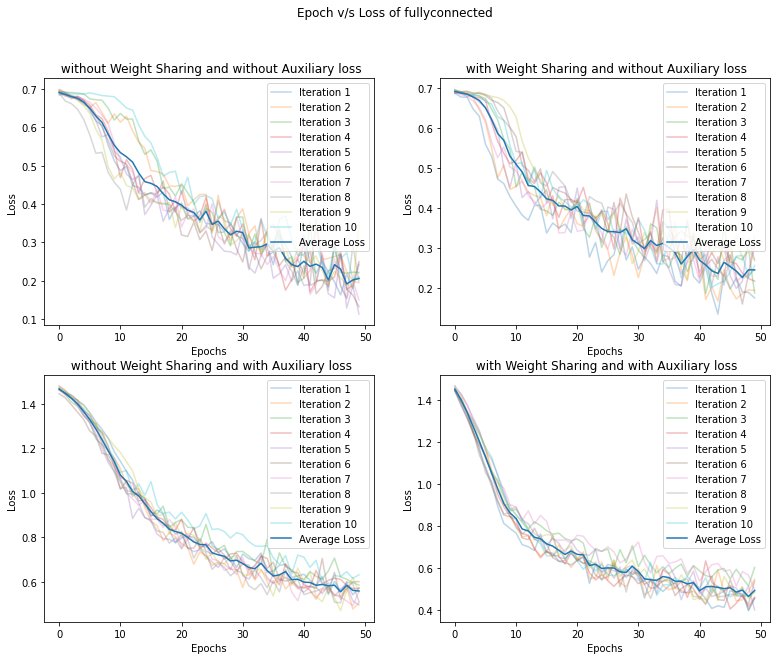

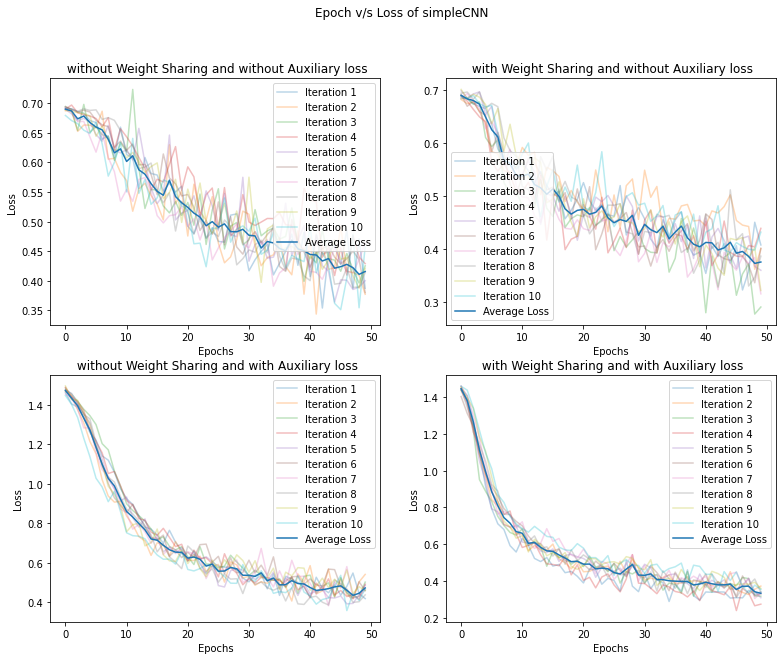

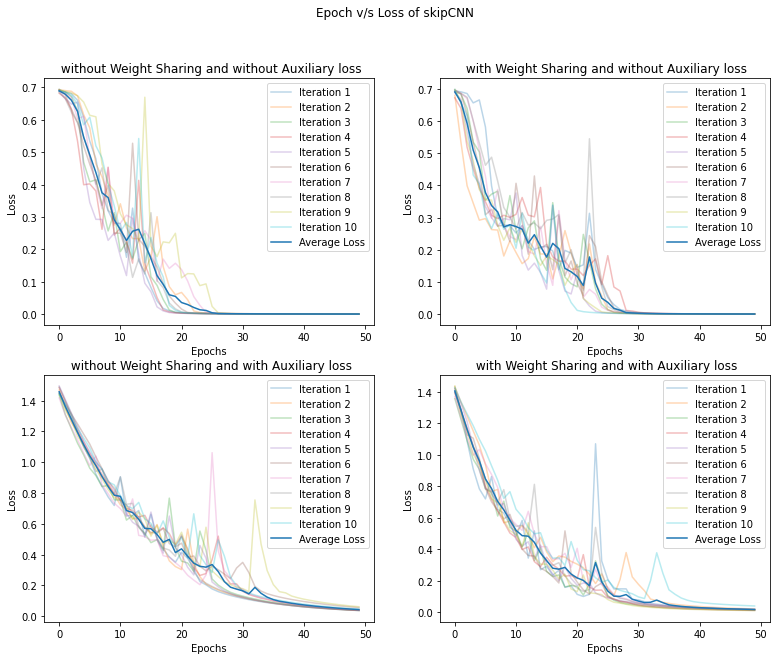

In [11]:
plt.rcParams["figure.figsize"] = (13,10)
for model_type in model_types_outputs: 
    title_part1 = model_type
    fig, ax = plt.subplots(nrows=2, ncols=2)
    for train_out, subax in zip(model_types_outputs[model_type], ax.flat):
        
        if train_out['weight_sharing']:
            title_part2 = " with Weight Sharing"
        else:
            title_part2 = " without Weight Sharing"
            
        if train_out['auxiliary_loss']:
            title_part3 = " and with Auxiliary loss"
        else:
            title_part3 = " and without Auxiliary loss"
            
        # plotting losses
        subax.set_xlabel("Epochs")
        subax.set_ylabel("Loss")
        plt.suptitle("Epoch v/s Loss of " + title_part1 )
        subax.set_title(title_part2 + title_part3)
        epoch_loss_list = train_out["loss"]
        for i in range(len(epoch_loss_list)):
            subax.plot(epoch_loss_list[i], label="Iteration {}".format(i+1), alpha=0.3)

        average_loss = np.mean(epoch_loss_list, axis=0)
        subax.plot(average_loss, label="Average Loss")
        subax.legend()

## Test Errors

In [12]:
error_model_options = []
no_ws_no_al_error = {}
ws_no_al_error = {}
no_ws_al_error = {}
ws_al_error = {}
for model_type in model_types_outputs: 
    title_part1 = model_type
    for train_out in model_types_outputs[model_type]:
        
        if train_out['weight_sharing'] and train_out['auxiliary_loss']:
            ws_al_error[title_part1] = train_out["error"]
        elif train_out['weight_sharing'] and not train_out['auxiliary_loss']:
            ws_no_al_error[title_part1] = train_out["error"]
        elif not train_out['weight_sharing'] and train_out['auxiliary_loss']:
            no_ws_al_error[title_part1] = train_out["error"]
        elif not train_out['weight_sharing'] and not train_out['auxiliary_loss']:
            no_ws_no_al_error[title_part1] = train_out["error"]

Text(0.5, 1.0, 'with Weight Sharing and with Auxiliary loss')

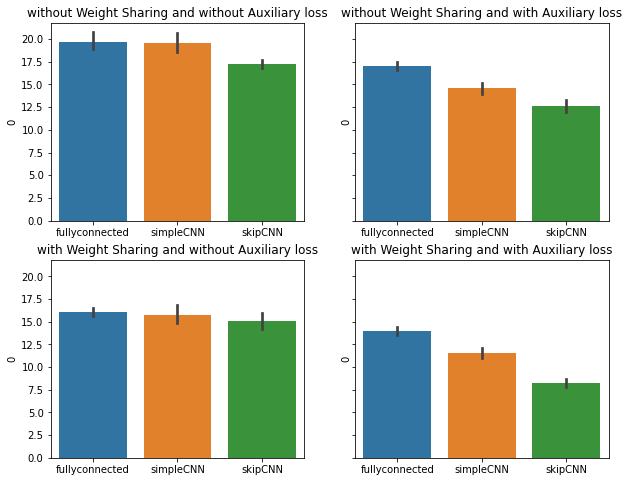

In [13]:
plt.rcParams["figure.figsize"] = (10,8)
f, axes = plt.subplots(2, 2, sharey=True)

df = pd.DataFrame(no_ws_no_al_error)
unstacked = df.unstack().to_frame()
sns.barplot(
    x=unstacked.index.get_level_values(0),
    y=unstacked[0], ax=axes[0,0]).set_title('without Weight Sharing and without Auxiliary loss')

df = pd.DataFrame(no_ws_al_error)
unstacked = df.unstack().to_frame()
sns.barplot(
    x=unstacked.index.get_level_values(0),
    y=unstacked[0], ax=axes[0,1]).set_title('without Weight Sharing and with Auxiliary loss')

df = pd.DataFrame(ws_no_al_error)
unstacked = df.unstack().to_frame()
sns.barplot(
    x=unstacked.index.get_level_values(0),
    y=unstacked[0], ax=axes[1,0]).set_title('with Weight Sharing and without Auxiliary loss')

df = pd.DataFrame(ws_al_error)
unstacked = df.unstack().to_frame()
sns.barplot(
    x=unstacked.index.get_level_values(0),
    y=unstacked[0], ax=axes[1,1]).set_title('with Weight Sharing and with Auxiliary loss')

## Plotting models for report

In [14]:
net_types = [(False, False)]
model_types = ['fullyconnected', 'simpleCNN', 'skipCNN']

for model_type in model_types:
    # Iterate for four possible cases
    for (use_weight_sharing, use_auxiliary_loss) in net_types:
        print("\nModel type:", model_type)
            
        # Define the training model
        if model_type == 'fullyconnected':
            model = fullyconnected(use_weight_sharing, use_auxiliary_loss)
        elif model_type == 'simpleCNN':
            model = simpleCNN(use_weight_sharing, use_auxiliary_loss)
        elif model_type == 'skipCNN':
            model = skipCNN(use_weight_sharing, use_auxiliary_loss)

        inp_ = torch.randn((1, 2, 14, 14))
        
        temp = skipCNN(False, False)

        input_names = ['Image_pair']
        output_names = ['Class']
        model.eval()
        torch.onnx.export(model, inp_, "./images/"+model_type+'.onnx', input_names=input_names, output_names=output_names)


Model type: fullyconnected

Model type: simpleCNN

Model type: skipCNN


# Part below not to be submitted

### BaseNet

In [15]:
# # Initialize parameters
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model_type = 'baseline'
# nb_iterations = 10
# nb_epochs = 50
# mini_batch_size = 100
# # Use normalised inputs
# m1 = train_input.mean()
# s1 = train_input.std()
# norm_train_input = train_input.sub_(m1).div_(s1)
# norm_test_input = test_input.sub_(m1).div_(s1)
# #
# print('Using device:', device)
# train_model(model_type, norm_train_input, train_target, train_classes, norm_test_input, test_target, test_classes, 
#             mini_batch_size, nb_epochs, nb_iterations)

### AlexNet

In [16]:
# # Initialize parameters
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model_type = 'alex'
# nb_iterations = 10
# nb_epochs = 50
# mini_batch_size = 100
# # Use normalised inputs
# m1 = train_input.mean()
# s1 = train_input.std()
# norm_train_input = train_input.sub_(m1).div_(s1)
# norm_test_input = test_input.sub_(m1).div_(s1)
# #
# print('Using device:', device)
# train_model(model_type, norm_train_input, train_target, train_classes, norm_test_input, test_target, test_classes, 
#             mini_batch_size, nb_epochs, nb_iterations)

### ResNet

In [17]:
# # Initialize parameters
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model_type = 'residual'
# nb_iterations = 10
# nb_epochs = 50
# mini_batch_size = 100
# # Use normalised inputs
# m1 = train_input.mean()
# s1 = train_input.std()
# norm_train_input = train_input.sub_(m1).div_(s1)
# norm_test_input = test_input.sub_(m1).div_(s1)
# #
# print('Using device:', device)
# train_model(model_type, norm_train_input, train_target, train_classes, norm_test_input, test_target, test_classes, 
#             mini_batch_size, nb_epochs, nb_iterations)

### Fully Connected Net

In [18]:
# # Initialize parameters
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model_type = 'fullyconnected'
# nb_iterations = 10
# nb_epochs = 50
# mini_batch_size = 100
# # Use normalised inputs
# m1 = train_input.mean()
# s1 = train_input.std()
# norm_train_input = train_input.sub_(m1).div_(s1)
# norm_test_input = test_input.sub_(m1).div_(s1)
# #
# print('Using device:', device)
# train_model(model_type, norm_train_input, train_target, train_classes, norm_test_input, test_target, test_classes, 
#             mini_batch_size, nb_epochs, nb_iterations)

In [19]:
# # For development purposes
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model_type = 'residual'
# nb_iterations = 3
# nb_epochs = 10
# mini_batch_size = 2
# #
# ex_train_input = train_input[0:10]
# ex_train_target = train_target[0:10]
# ex_train_classes = train_classes[0:10]
# #
# ex_test_input = test_input[0:10]
# ex_test_target = test_target[0:10]
# ex_test_classes = test_classes[0:10]
# #
# print('Using device:', device)
# train_model(model_type, ex_train_input, ex_train_target, ex_train_classes, ex_test_input, ex_test_target, ex_test_classes, 
#             mini_batch_size, nb_epochs, nb_iterations)

In [20]:
# # Without normalisation
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model_type = 'shallow'
# nb_iterations = 10
# nb_epochs = 50
# mini_batch_size = 100
# #
# print('Using device:', device)
# train_model(model_type, train_input, train_target, train_classes, test_input, test_target, test_classes, 
#             mini_batch_size, nb_epochs, nb_iterations)

In [21]:
# m1 = train_input.mean()
# s1 = train_input.std()
# x_train=train_input.sub_(m1).div_(s1)
# x_test=test_input.sub_(m1).div_(s1)

# def execute_norm(model_nm, nb_iterations, nb_epochs=20):
#     model=None
#     nb_epochs = nb_epochs
#     mini_batch_size = 50
#     eta = 1e-1
#     use_gpu=True
#     tot_err=0
#     for k in range(nb_iterations):
#         if(model_nm=="base"):
#             model = Baseline_Net()
#         else:
#             model = WtSharing_Net()
#         optimizer = torch.optim.SGD(model.parameters(), lr = eta)
#         criterion = nn.CrossEntropyLoss()#MSELoss()
#         train_model(model, x_train, train_target, train_classes, mini_batch_size, optimizer, criterion, nb_epochs, use_gpu)
#         nb_test_errors = compute_nb_errors(model, x_test, test_target, test_classes, mini_batch_size,use_gpu)
#         tot_err+=nb_test_errors
#         print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / x_test.size(0),
#                                                       nb_test_errors, x_test.size(0)))
#     print("Avg. Error: ",(tot_err/(10*nb_iterations)), "%")    
